In [1]:
import numpy as np
import pandas as pd
import time

import ypred_module as ypm
import exact_cme as cme
import train_conditional as train
import tools_conditional as tools
import direct_module as direct

import matplotlib.pyplot as plt
import seaborn as sns

-----
# Figure 2 : Performance



### Figure 2a: Time vs. Hellinger Distance 
Plotting timing vs. hellinger distance (normalized by state size of PMF) for various methods of calculating and approximating full Probability Mass Functions.

In [3]:
compare_array_norm_hellinger = np.load('./results/compare_array_norm_hellinger.npy')
direct_hellinger = np.load('./results/direct_model256_3_4t_hellinger_norm.npy')
direct_times = np.load('./results/direct_model256_3_4t_times_norm.npy')

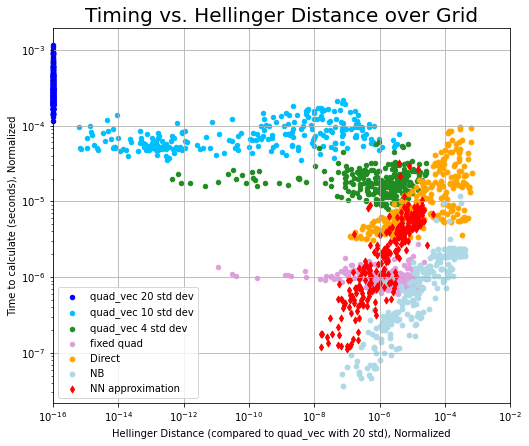

In [4]:
start = 0
stop = 256


fig, ax = plt.subplots(figsize=(8.2, 6.9))

#ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.scatter(compare_array_norm_hellinger[0,start:stop,1]+1e-16,compare_array_norm_hellinger[0,start:stop,0],
            label='quad_vec 20 std dev',s=20,c='blue',clip_on=False)
plt.scatter(compare_array_norm_hellinger[1,start:stop,1],compare_array_norm_hellinger[1,start:stop,0],
            label='quad_vec 10 std dev',s=20,c='deepskyblue')
plt.scatter(compare_array_norm_hellinger[2,start:stop,1],compare_array_norm_hellinger[2,start:stop,0],
            label='quad_vec 4 std dev',s=20,c='forestgreen')
plt.scatter(compare_array_norm_hellinger[3,start:stop,1],compare_array_norm_hellinger[3,start:stop,0],
            label='fixed quad',s=20,c='plum')
plt.scatter(direct_hellinger[start:stop],direct_times[start:stop],
            label='Direct',s=23,c='orange')
plt.scatter(compare_array_norm_hellinger[5,start:stop,1],compare_array_norm_hellinger[5,start:stop,0],
            label='NB',s=23,c='lightblue')
plt.scatter(compare_array_norm_hellinger[4,start:stop,1],compare_array_norm_hellinger[4,start:stop,0],
            label='NN approximation',s=23,c='red',marker='d')


plt.xlabel('Hellinger Distance (compared to quad_vec with 20 std), Normalized')
plt.ylabel('Time to calculate (seconds), Normalized')
plt.title("Timing vs. Hellinger Distance over Grid", fontdict={'fontsize': 20})
plt.grid()
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-16,1e-2);

### Figure 2b: Hellinger Distances over PMF Grids

In [5]:
data_array = train.load_data(3,'./data/','256_test_full')

# NN_hellinger = np.zeros(256*3)
# rand_hellinger = np.zeros(256*3)
# NB_hellinger = np.zeros(256*3)

# for i in range(256*3):

#     pdf = data_array[i][1]
#     p_in = data_array[i][0]

#     nas_range = np.arange(pdf.shape[0])
#     mat_range = np.arange(pdf.shape[1])

#     predicted = ypm.get_prob(p_in,nas_range,mat_range)
#     predicted_rand = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=True)
#     NN_hellinger[i] = tools.hellinger(predicted,pdf)
#     rand_hellinger[i] =  tools.hellinger(predicted_rand,pdf)
    
#     N,M = np.meshgrid(range(pdf.shape[0]),range(pdf.shape[1]),indexing='ij')
#     NB = ypm.approximate_conditional_tensorval(p_in,N,M).detach().numpy()
#     NB_hellinger[i] = tools.hellinger(pdf,NB)


# # TiMING
# times_NN_onepoint = np.zeros(256*3)
# times_NB_onepoint = np.zeros(256*3)

# for i in range(256*3):
#     rate_vec = data_array[i][0]

#     t1 = time.time()
#     pred = ypm.get_prob(rate_vec,n_range=np.arange(0),m_range=np.arange(0))
#     t2 = time.time()

#     times_NN_onepoint[i] = (t2-t1)
    
#     t1 = time.time()
#     N,M = np.meshgrid(np.arange(0),np.arange(0),indexing='ij')
#     y_NB = ypm.approximate_conditional_tensorval(rate_vec,N,M).detach().numpy()
#     t2 = time.time()

#     times_NB_onepoint[i] = (t2-t1)

In [6]:
NN_hellinger = np.load('./results/NN_hellinger.npy')
NB_hellinger = np.load('./results/NB_hellinger.npy')
rand_hellinger = np.load('./results/rand_hellinger.npy')

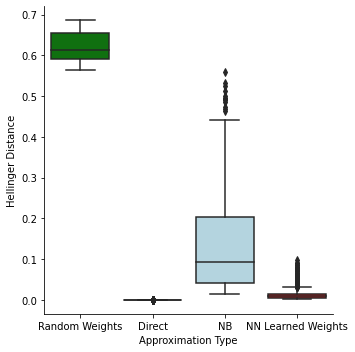

In [8]:
hellinger_data = {'Approximation Type': ['Random Weights']*256*3+['Direct']*256*3+ ['NB']*256*3+ ['NN Learned Weights']*256*3,
        'Hellinger Distance': np.concatenate((rand_hellinger,direct_hellinger,NB_hellinger,NN_hellinger)) }
hellinger_df = pd.DataFrame.from_dict(hellinger_data) 
my_pal = {"NN Learned Weights": "red", "NB": "lightblue", "Direct":"darkorange",'Random Weights':'g'}


sns.catplot(x="Approximation Type", y='Hellinger Distance', kind="box",  data=hellinger_df,palette=my_pal);

### Figure 2c: Timing for single point

In [9]:
NN_times_onepoint = np.load('./results/NN_times_onepoint.npy')
NB_times_onepoint = np.load('./results/NB_times_onepoint.npy')
direct_times_onepoint = np.load('./results/direct_model256_3_4t_times_onepoint.npy')

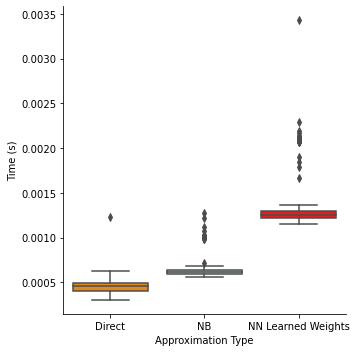

In [11]:
data_time = {'Approximation Type': ['Direct']*256*3+['NB']*256*3+ ['NN Learned Weights']*256*3,
        'Time (s)': np.concatenate((direct_times_onepoint,NB_times_onepoint,NN_times_onepoint)) }

time_df = pd.DataFrame.from_dict(data_time) 

sns.catplot(x="Approximation Type", y='Time (s)', kind="box",  data=time_df, palette = my_pal);

### Figure 2d: Comparing PMFs

/home/mcarilli/CME/git/CME_approximations/Paper/ypred_module.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(m_range+1,dtype=torch.long)
/home/mcarilli/CME/git/CME_approximations/Paper/ypred_module.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MU, VAR, STD, xmax = [torch.tensor(x) for x in train.get_moments(p)]


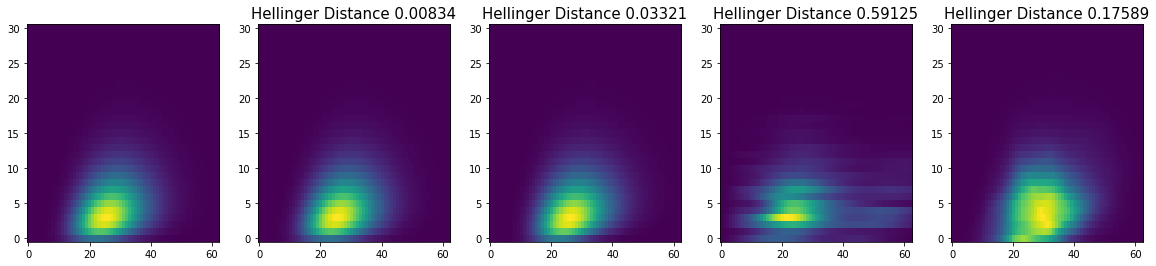

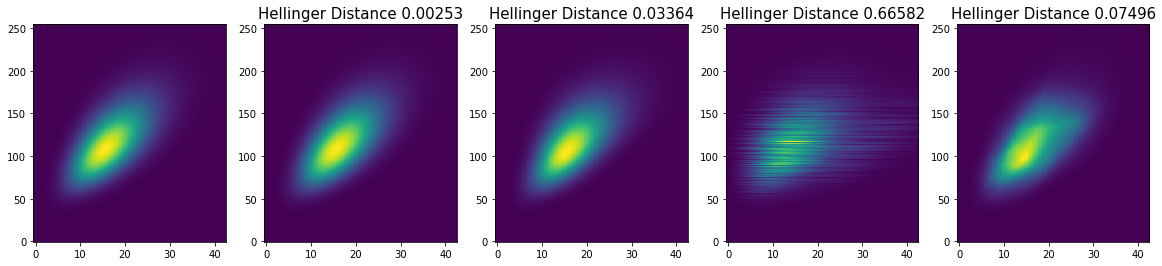

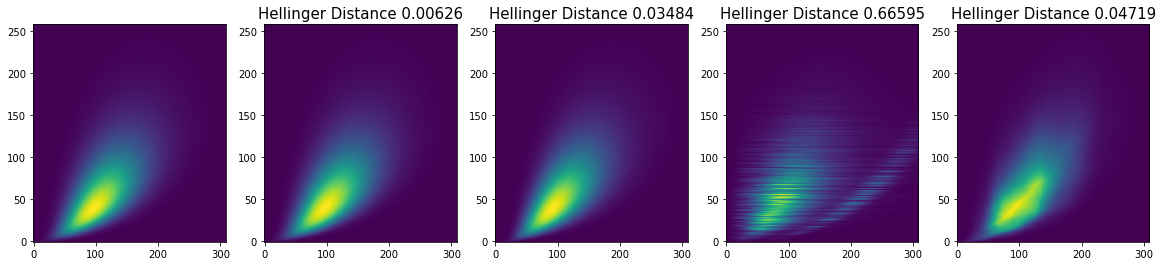

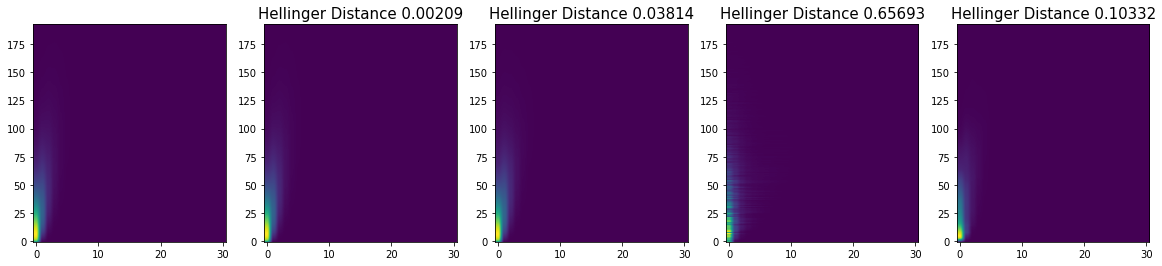

In [12]:
indices = [8,11,22,20]

for i in indices:
    

    pdf = data_array[i][1]
    p_in = data_array[i][0]

    nas_range = np.arange(pdf.shape[0])
    mat_range = np.arange(pdf.shape[1])

    predicted = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=False)
    predicted_rand = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=True)
    predicted_direct = direct.predict_pmf(p_in,nas_range[-1]+1,mat_range[-1]+1)
    N,M = np.meshgrid(range(pdf.shape[0]),range(pdf.shape[1]),indexing='ij')
    NB = ypm.approximate_conditional_tensorval(p_in,N,M).detach().numpy()


    fig1,ax1=plt.subplots(nrows=1,ncols=5,figsize=(20,4))

    ax1[0].imshow(pdf,aspect='auto')
    ax1[0].invert_yaxis()


    hell = tools.hellinger(pdf,predicted)
    ax1[1].imshow(predicted,aspect='auto')
    ax1[1].invert_yaxis()
    ax1[1].set_title(f'Hellinger Distance {hell:.5f}',fontdict = {'fontsize' : 15})
    # ax1[1].set_xlabel('# mature')
    # ax1[1].set_ylabel('# nascent')


    hell_NB = tools.hellinger(pdf,NB)
    ax1[2].imshow(NB,aspect='auto',)
    ax1[2].invert_yaxis()
    ax1[2].set_title(f'Hellinger Distance {hell_NB:.5f}',fontdict = {'fontsize' : 15})
    #ax1[2].set_xlabel('# mature')
    #ax1[2].set_ylabel('# nascent')



    hell_rand = tools.hellinger(pdf,predicted_rand)
    ax1[3].imshow(predicted_rand,aspect='auto',)
    ax1[3].invert_yaxis()
    ax1[3].set_title(f'Hellinger Distance {hell_rand:.5f}',fontdict = {'fontsize' : 15})
    #ax1[3].set_xlabel('# mature')
    #ax1[3].set_ylabel('# nascent')


    hell_direct = tools.hellinger(pdf,predicted_direct)
    ax1[4].imshow(predicted_direct,aspect='auto',)
    ax1[4].invert_yaxis()
    ax1[4].set_title(f'Hellinger Distance {hell_direct:.5f}',fontdict = {'fontsize' : 15});
    #ax1[4].set_xlabel('# mature')
    #ax1[4].set_ylabel('# nascent')

    fig.tight_layout()
    plt.show();

-----

# Figure 3


### Figure 3a: Training/validation loss for final model

In [13]:
best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)

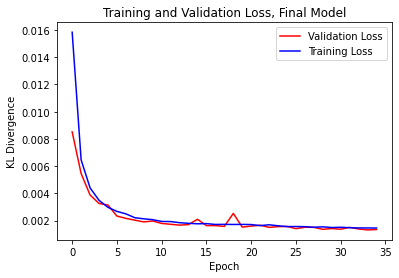

In [15]:
best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)
best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)
train_klds = best_model_loss[2]
valid_klds = best_model_loss[3]

plt.plot(valid_klds,label='Validation Loss',c='red')
plt.plot(train_klds,label='Training Loss',c='blue')
plt.legend()
plt.title('Training and Validation Loss, Final Model')
plt.ylabel('KL Divergence')
plt.xlabel('Epoch');


### Figure 3b: Timing for training 

Training time for a varying number of *conditional examples* with 5, 10, or 20 kernel functions. 

In [20]:
times_5npdf = np.load('./results/timing_5npdf.npy')
times_10npdf = np.load('./results/timing_10npdf.npy')
times_20npdf = np.load('./results/timing_20npdf.npy')

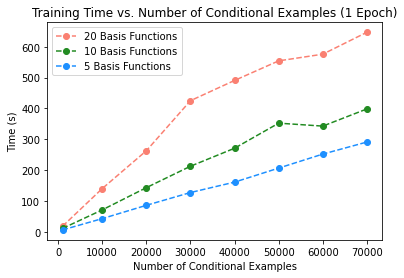

In [21]:
num_conditionals = times_5npdf[0,:]
plt.plot(num_conditionals,times_20npdf[1,:],label='20 Basis Functions',c='salmon',marker='o',linestyle='--')
plt.plot(num_conditionals,times_10npdf[1,:],label='10 Basis Functions',c='forestgreen',marker='o',linestyle='--')
plt.plot(num_conditionals,times_5npdf[1,:],label='5 Basis Functions',c='dodgerblue',marker='o',linestyle='--')
plt.title('Training Time vs. Number of Conditional Examples (1 Epoch)')
plt.xlabel('Number of Conditional Examples')
plt.ylabel('Time (s)')
plt.legend();

### Figure 3c-e: Varying Nodes, Kernel Functions, Examples
Plot the 5th, 95th percentile and mean Kullback-Leibler divergence for the testing parameters (stored in ./data/256_test_i.npy) as a function of changing the number of hidden nodes in the two hidden layers, the number of kernel functions, and the number of training parameters. 

In [23]:
klds_hid = np.load('./results/testing_klds_hid.npy',allow_pickle=True)
klds_npdf = np.load('./results/testing_klds_npdf.npy',allow_pickle=True)
klds_param = np.load('./results/testing_klds_param.npy',allow_pickle=True)

In [24]:
# get mean and quantiles for best model 
main_mean = np.mean(klds_param[-1,1])
main_95th = np.percentile(klds_param[-1,1],95)
main_5th = np.percentile(klds_param[-1,1],5)

### Figure 3c: Varying Nodes in Hidden Layers

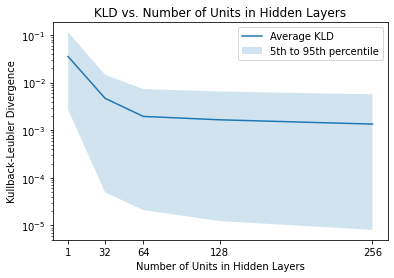

In [25]:
hid_95th = [ np.percentile(hid[1],95) for hid in klds_hid ] 
hid_5th = [ np.percentile(hid[1],5) for hid in klds_hid ] 
hid_means =  [ np.mean(hid[1]) for hid in klds_hid ] 


# add for best model
hid_units = [hid[0] for hid in klds_hid]
hid_units.append(256)
hid_means.append(main_mean)
hid_95th.append(main_95th)
hid_5th.append(main_5th)


fig, ax = plt.subplots()
ax.plot(hid_units[:], hid_means[:], '-',label='Average KLD')
ax.fill_between(hid_units[:], hid_95th[:], hid_5th[:], alpha=0.2, label = '5th to 95th percentile')
plt.title('KLD vs. Number of Units in Hidden Layers')
plt.ylabel('Kullback-Leubler Divergence')
plt.xlabel('Number of Units in Hidden Layers')
plt.xticks(hid_units[:], hid_units[:])
plt.yscale('log')
plt.legend();

### Figure 3d: Varying Number of Kernel Functions

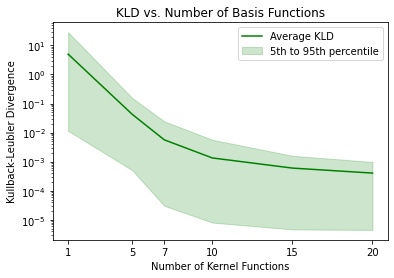

In [26]:
npdf = [ p[0] for p in klds_npdf]
npdf.insert(3,10)

npdf_95th = [ np.percentile(p[1],95) for p in klds_npdf ] 
npdf_95th.insert(3,main_95th)
npdf_5th = [ np.percentile(p[1],5) for p in klds_npdf] 
npdf_5th.insert(3,main_5th)
npdf_means =  [ np.mean(p[1]) for p in klds_npdf ] 
npdf_means.insert(3,main_mean)

npdf = [ p[0] for p in klds_npdf]
npdf.insert(3,10)


fig, ax = plt.subplots()
ax.plot(npdf[:], npdf_means[:], '-',label='Average KLD',c='green')
ax.fill_between(npdf[:], npdf_95th[:], npdf_5th[:], alpha=0.2, label = '5th to 95th percentile',color='green')
plt.title('KLD vs. Number of Basis Functions')
plt.ylabel('Kullback-Leubler Divergence')
plt.xlabel('Number of Kernel Functions')
plt.xticks(npdf[:], npdf[:])
plt.yscale('log')
plt.legend();

### Figure 3e: Varying Number of Example Rate Vectors

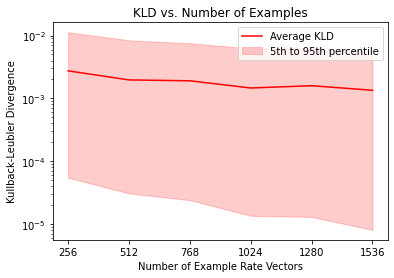

In [27]:
param_95th = [ np.percentile(p[1],95) for p in klds_param ] 
param_5th = [ np.percentile(p[1],5) for p in klds_param ] 
param_means =  [ np.mean(p[1]) for p in klds_param ] 


params = 256*(np.arange(6)+1)

fig, ax = plt.subplots()
ax.plot(params[:], param_means[:], '-',label='Average KLD',c='red')
ax.fill_between(params[:], param_95th[:], param_5th[:], alpha=0.2, label = '5th to 95th percentile',color='red')
plt.title('KLD vs. Number of Examples')
plt.ylabel('Kullback-Leubler Divergence')
plt.xlabel('Number of Example Rate Vectors')
plt.xticks(params[:], params[:])
#plt.ylim(-0.001,0.02)
plt.yscale('log')
plt.legend();